In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

from transformers import Trainer, TrainingArguments, AdamW


import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'sshleifer/tiny-gpt2'
#model_name = 'gpt2'

In [2]:
# tokenizer to process the text and include a padding and truncation strategy
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [3]:
# loading the model and specifying the number of expected labels.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

model.config.pad_token_id = model.config.eos_token_id

pytorch_model.bin:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sshleifer/tiny-gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
df2=pd.read_csv('cleaned_winter_data.csv')
df2 = df2.drop('Requires further investigation to resolve?', axis=1)
df2['Description of problem'] = (df2['Received from:'] + ' ' + df2['Description of problem'].fillna('')).astype(str)
df2 = df2[df2['Sent staff to room?'] != ' ']
df2['Sent staff to room?'] = df2['Sent staff to room?'].fillna(0)
dataset=df2.reindex(['Description of problem','Sent staff to room?'], axis=1)
dataset.head()

,Description of problem,Sent staff to room?
0,OI 8170 jr. station enable request from kyle,0
1,BA 1180 wanted to know if his log in would wor...,0
2,UC 85 log in request,0
3,ES 4001 mike showing prof how intercom works,0
4,BL 313 prof testing powerpoint for next week,0


In [5]:
import string
def remove_punctuation_and_quotes(text):
    return ''.join(char.lower() for char in text if char not in string.punctuation + "'\"")
dataset['Description of problem'] = dataset['Description of problem'].apply(remove_punctuation_and_quotes)
dataset['Sent staff to room?'] = (dataset['Sent staff to room?'].map({'1': 1, '0': 0})).fillna(0)

In [6]:
X= dataset['Description of problem'].tolist()
y= dataset['Sent staff to room?'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [7]:
#X_train

In [8]:
#custom dataset class

class ClassificationDataset(Dataset):

    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key,val in self.sentences.items()} #dictionary where each key is the name of a sentence feature, and the corresponding value is a PyTorch tensor of the sentences at the specified index.
        item['labels'] = torch.tensor(self.labels[index]) # adding label key to the item dictionary
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
# Creating instance of train and validation dataset

train_dataset = ClassificationDataset(tokenizer(X_train, truncation=True) , y_train)
val_dataset = ClassificationDataset(tokenizer(X_val, truncation=True) , y_val)

# for batch processing and padding sequences to have the same length.
data_collator = DataCollatorWithPadding(tokenizer)

# Data loaders for train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=10, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=10, collate_fn=data_collator)

#defining hyperparameters
learning_rate = 1e-4
epochs=30

optimizer = AdamW(model.parameters(), lr=learning_rate)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Training loop

avg_train_acc = []
avg_train_loss = []

avg_val_acc = []
avg_val_loss = []


for epoch in range(epochs):

    print("Epoch:",epoch+1)

    #Training
    train_accuracy = 0
    train_loss = 0

    model.train()

    for batch in train_dataloader:

        batch = {k: v.to(device) for k,v in batch.items()}

        # forwad pass
        out = model(**batch)
        loss = out.loss

        train_loss += loss
        train_loss = train_loss.detach()

        softmax_logits = nn.Softmax(dim=-1)(out.logits)
        pred = torch.argmax(softmax_logits,dim=-1)

        labels = batch['labels']

        pred = pred.reshape(labels.shape)
        train_accuracy += sum(pred == labels).detach()

        #Backward Pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    avg_train_acc.append(train_accuracy.cpu()/len(train_dataset))
    avg_train_loss.append(train_loss.cpu()/len(train_dataloader))



    #Validation loop
    val_accuracy = 0
    val_loss = 0

    model.eval()
    for batch in val_dataloader:

        batch = {k: v.to(device) for k,v in batch.items()}

        with torch.no_grad():
            out = model(**batch)
            labels = batch['labels'].to(device)

            softmax_logits = nn.Softmax(dim=-1)(out.logits)
            pred = torch.argmax(softmax_logits,dim=-1)

            pred = pred.reshape(labels.shape)
            val_accuracy += sum(pred == labels)

            val_loss += out.loss

    avg_val_acc.append(val_accuracy.cpu()/len(val_dataset))
    avg_val_loss.append(val_loss.cpu()/len(val_dataloader))


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


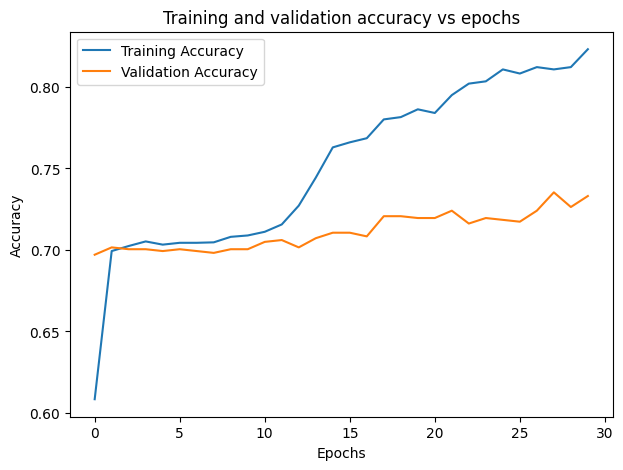

In [11]:
# Plotting the training and validation accuracy vs epochs

plt.figure(figsize=(7, 5))
plt.plot(torch.arange(epochs) , avg_train_acc, label='Training Accuracy');
plt.plot(torch.arange(epochs) , avg_val_acc, label='Validation Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.title('Training and validation accuracy vs epochs')
plt.legend();

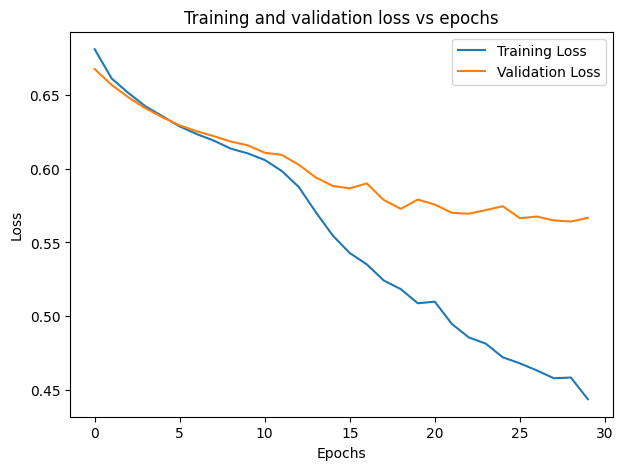

In [14]:
# Plotting the training and validation loss vs epochs

plt.figure(figsize=(7, 5))
plt.plot(torch.arange(epochs) , avg_train_loss, label='Training Loss');
plt.plot(torch.arange(epochs) , avg_val_loss, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.title('Training and validation loss vs epochs')
plt.legend();

In [15]:
print("The average Training accuracy over ",epochs, " epochs is ",avg_train_acc[-1])
print("The average Validation accuracy over ",epochs, " epochs is ", avg_val_acc[-1])

The average Training accuracy over  30  epochs is  tensor(0.8232)
The average Validation accuracy over  30  epochs is  tensor(0.7331)


In [23]:
test="SK 100 mistake"
encoded_input = tokenizer(test, return_tensors='pt')
output = model(**encoded_input)
# 4. Get predictions
logits = output.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [25]:
test="SF 1101 log me in remotely"
encoded_input = tokenizer(test, return_tensors='pt')
output = model(**encoded_input)
# 4. Get predictions
logits = output.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [27]:
test="SS 2135 can you do DGE reset remotely"
encoded_input = tokenizer(test, return_tensors='pt')
output = model(**encoded_input)
# 4. Get predictions
logits = output.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [24]:
test="BA 1170 My projector screen is frozen"
encoded_input = tokenizer(test, return_tensors='pt')
output = model(**encoded_input)
# 4. Get predictions
logits = output.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 1


In [28]:
test="Im in room SS1069. My classroom speakers are making a buzzing noise."
encoded_input = tokenizer(test, return_tensors='pt')
output = model(**encoded_input)
# 4. Get predictions
logits = output.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0
